In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta
import json
from util import * 
from yield_estimation import *

columns = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

Omega = np.load("../genai/scenarios.npy")


In [13]:
VERBOSE = True
with open("params.json") as f:
    params = json.load(f)

productions = []
for s in range(Omega.shape[0]):
    df_season = pd.DataFrame(Omega[s], columns=columns)

    fixed_window = pd.read_csv('../genai/fixed_window.csv', index_col=0)
    fixed_window.columns = columns
    df_season = pd.concat([fixed_window, df_season])
    try:     
        if len(df_season) < 180:
            print(f"Warning: Season data is short ({len(df_season)} days). Using available data.")
        else:
            df_season = df_season.iloc[:180]
        print(f"Loaded {len(df_season)} days of weather data for simulation.")
    except FileNotFoundError:
        print("="*50)
        print("ERROR: Data file not found. Please re-run Cell 4 to download the data.")
        print("="*50)
    df_season.reset_index(inplace=True)

    start_date = date(2024, 8, 30)
    date_list = [start_date + timedelta(days=x) for x in range(1, 181)]
    df_season['DATE'] = date_list
    df_season.DATE = pd.to_datetime(df_season.DATE)
    df_season.set_index('DATE', inplace=True)
    if "RH2M" in df_season.columns:
        df_season["RH2M"] = df_season["RH2M"].clip(lower=0, upper=100)

    for col in ["PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
        if col in df_season.columns:
            df_season[col] = df_season[col].clip(lower=0)

    df_season["TAVG"] = (df_season["T2M_MAX"] + df_season["T2M_MIN"]) / 2.0

    allsky_mean = float(df_season["ALLSKY_SFC_SW_DWN"].mean())

    if allsky_mean < 12.0:
        rad_factor = 3.6
    else:
        rad_factor = 1.0

    df_season["SRAD_MJ"] = df_season["ALLSKY_SFC_SW_DWN"] * rad_factor          # for [Eq. 32] (energy)
    df_season["PAR_MJ"]  = df_season["SRAD_MJ"] * 0.48                          # for [Eq. 4] (biomass driver)

    es = 0.6108 * np.exp(17.27 * df_season["TAVG"] / (df_season["TAVG"] + 237.3))
    ea = es * (df_season["RH2M"] / 100.0)
    df_season["VPD_kPa"] = np.maximum(0.1, es - ea)

    df_season["RAIN_mm"] = df_season["PRECTOTCORR"]

    yield_estimation = get_estimation(df_season, params, VERBOSE=VERBOSE)

    print(yield_estimation)
    productions.append(yield_estimation)

Loaded 180 days of weather data for simulation.
[PHENO] 2024-09-17 dormancy released | chill_cum=356.1
[PHENO] 2024-10-10 anthesis reached
[HI] 2024-10-16 HIa fixed | HIws=0.350, HIhs=0.350, HIa=0.350

FINAL AUDIT (Chile) | LOC
Seasons evaluated (SEASON_YEAR): [2024]
Phenology models: Chill=unichill | Forcing=logistic
Harvest DOY: 120  | Irrigation threshold FTSW=0.20
--------------------------------------------------------------------------------
Average Yield (DM):      5475 kg/ha
Average Yield (Fresh*):  12044 kg/ha   (*fresh_factor=2.2)
Average Irrigation:      153 mm/season-year
Alternate Bearing Index: nan   [Eq. 41]
--------------------------------------------------------------------------------
12044.424364460709
Loaded 180 days of weather data for simulation.
[PHENO] 2024-09-17 dormancy released | chill_cum=356.1
[PHENO] 2024-10-10 anthesis reached
[HI] 2024-10-16 HIa fixed | HIws=0.350, HIhs=0.350, HIa=0.350

FINAL AUDIT (Chile) | LOC
Seasons evaluated (SEASON_YEAR): [2024]
P

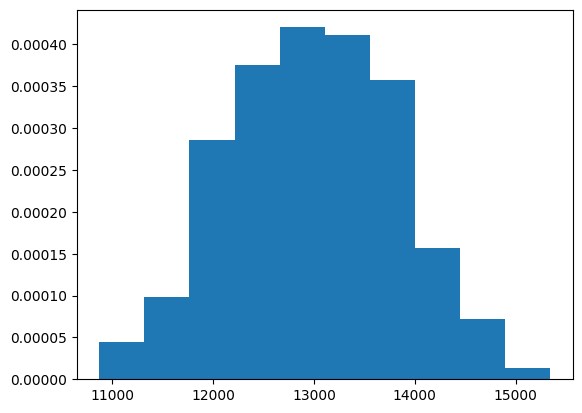

In [14]:
plt.hist(productions, density=True)
plt.show()